
\ev charging

In [225]:
#Packages
from gurobipy import Model, GRB, quicksum
import pandas as pd
import numpy as np
import folium
import math
import random
import builtins
import collections
import matplotlib.pyplot as plt

In [68]:
#Load datasets
dfp = pd.read_csv('Electric_Vehicle_Population_Data.csv') #dataframe for ev population
dfcs = pd.read_csv('Public_EV_Charging_Stations.csv') #dataframe for charging stations
dfa = pd.read_csv('wa.csv', low_memory = False, index_col = 'HASH') #dataframe for addresses

#### Visualizations

In [313]:
m = folium.Map(location=[lat1[0], lon1[0]], zoom_start=13)

for i in range(len(lat1)):
    folium.CircleMarker(
        location=[lat1[i], lon1[i]],
        radius=5,
        color='red',
    ).add_to(m)

for j in range(len(lat2)):
    folium.CircleMarker(
        location=[lat2[j], lon2[j]],
        radius=8,  # Adjust the size of the circle here
        color='blue',
    ).add_to(m)
m

In [189]:
group = dfp.groupby("Postal Code")
folium_df = group["VIN (1-10)"].count().to_frame("number of EVs")
folium_df.reset_index(inplace=True)

m = folium.Map(location=[47.5, -120.75], zoom_start=7)
c = folium.Choropleth(
    geo_data="Postal Code Boundaries.geojson",
    data=folium_df,
    columns=["Postal Code", "number of EVs"],
    key_on="feature.properties.ZCTA5CE10",
    fill_color="YlOrRd",
    bins=25,
    legend_name="Number of EVs",
    highlight=True
).add_to(m)

c.geojson.add_child(folium.features.GeoJsonTooltip(["ZCTA5CE10"], labels=False))

display(m)

In [190]:
group = dfcs.groupby("Zipcode")
folium_df = group["Station_Name"].count().to_frame("number of charging stations")
folium_df.reset_index(inplace=True) 

m = folium.Map(location=[47.5, -120.75], zoom_start=7)
c = folium.Choropleth(
    geo_data="Postal Code Boundaries.geojson",
    data=folium_df,
    columns=["Zipcode", "number of charging stations"],  
    key_on="feature.properties.ZCTA5CE10",
    fill_color="YlOrRd",
    bins=25,
    legend_name="Number of Charging Stations",
    highlight=True
).add_to(m)

c.geojson.add_child(folium.features.GeoJsonTooltip(["ZCTA5CE10"], labels=False))

display(m)

In [53]:
m = folium.Map(location=[lat1[0], lon1[0]], zoom_start=7)

lat_stations = dfcs['Latitude'].tolist()
lon_stations = dfcs['Longitude'].tolist()

for j in range(len(lat_stations)):
    folium.CircleMarker(
        location=[lat_stations[j], lon_stations[j]],
        radius=2,  # Adjust the size of the circle here
        color='blue',
    ).add_to(m)
m

In [214]:
# dfd = pd.read_csv('uszips.csv') #dataframe for zipcodes
# dfd = dfd.loc[dfd['state_id'] == 'WA']
# dfd['Area'] = dfd['population']/dfd['density']

# pc = dfd['zip'].tolist()
# num = ev_count(pc)
# denom = dfd['Area'].tolist()

# values = []
# for i in range(len(num)):
#     values.append(num[i]/denom[i])

# data = {
#     'zip': pc, 
#     'density': values 
# }

# df = pd.DataFrame(data)

# geojson_path = 'Postal Code Boundaries.geojson'

# folium_map = folium.Map(location=[47.5, -120.75], zoom_start=7) 

# folium.Choropleth(
#     geo_data=geojson_path,
#     name='choropleth',
#     data=df,
#     columns=['zip', 'density'], 
#     key_on='feature.properties.ZCTA5CE10', 
#     fill_color='YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.2,
#     legend_name='Density'
# ).add_to(folium_map)

# folium_map

#### Data Cleaning

In [215]:
#Parameters
postal_codes = ['98104', '98134', '98144']
city = 'Seattle'
total = dfp.shape[0]

In [216]:
#dfcs cleaning
dfcs = dfcs.loc[dfcs['Zipcode'].isin(postal_codes)]
dfcs = dfcs.loc[dfcs['Access_Hours'] == '24 hours daily']
dfcs = dfcs.drop(dfcs[dfcs.Restricted_Access == True].index)
dfcs['Plugs'] = dfcs['EV_Level1_EVSE_Ports'] + dfcs['EV_Level2_EVSE_Ports'] + dfcs['EV_DC_Fast_Ports']

In [217]:
dfp = dfp.loc[dfp['City'] == city]
def ev_count(pc):
    n = []
    for i in pc:
        n.append(dfp.loc[dfp['Postal Code'] == float(i)].shape[0])
    return n

In [218]:
#Random generating addresses
dfa = dfa.loc[dfa['POSTCODE'].isin(postal_codes)]
dfa = dfa.dropna(subset=['CITY'])

per_postcode_weights = collections.Counter(list(builtins.map(int, dfp["Postal Code"].dropna())))

dfa2 = list(dfa.POSTCODE)
new_weights = []
for postcode in dfa2:
    new_weights.append(per_postcode_weights[int(postcode)])

def generate_address(n):
    dfa1 = list(dfa.index)
    selected_addresses = random.choices(dfa1, weights=new_weights, k=n)
    return dfa.loc[selected_addresses]

In [219]:
cars = generate_address(70)
lat1 = cars['LAT'].tolist()
lon1 = cars['LON'].tolist()
lat2 = dfcs['Latitude'].tolist()
lon2 = dfcs['Longitude'].tolist()

In [220]:
def haversine(lat1, lon1, lat2, lon2):
    R = 3958.8 #Radius of the Earth in miles
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [221]:
def distance_matrix(lat1, lon1, lat2, lon2):
    distance = np.zeros((len(lat1), len(lat2)))
    for i in range(len(lat1)):
        for j in range(len(lat2)):
            distance[i, j] = haversine(lon1[i], lat1[i], lon2[j], lat2[j])
    return distance

#### Optimization Model

In [311]:
m = Model("ev_charging")

d = distance_matrix(lat1, lon1, lat2, lon2)
I = range(len(lat1))  # Postal codes
J = range(len(lat2))  # Charging stations
Capacity = dfcs['Plugs'].tolist()

x = {}
for i in I:
    for j in J:
        x[i,j] = m.addVar(vtype=GRB.BINARY, name = f"x_{i}{j}", lb=0)

m.setObjective(quicksum(d[i,j] * x[i, j] for i in I for j in J), GRB.MINIMIZE)

for j in J:
    m.addConstr(quicksum(x[i,j] for i in I) <= Capacity[j])

for i in I:
    m.addConstr(quicksum(x[i,j] for j in J) == 1, f"EV_Assignment_{i}")

m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 114 rows, 3080 columns and 6160 nonzeros
Model fingerprint: 0x6b2faf00
Variable types: 0 continuous, 3080 integer (3080 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 127.0478801
Presolve time: 0.01s
Presolved: 114 rows, 3080 columns, 6160 nonzeros
Variable types: 0 continuous, 3080 integer (3080 binary)
Found heuristic solution: objective 123.0007928

Root relaxation: objective 1.131509e+02, 817 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     113.1508764  113.15088  0.00%    

#### Solution

In [312]:
if m.status == GRB.OPTIMAL:
    print(m.objVal)
    for i in I:
        for j in J:
            if x[i,j].x > 0.5:
                n = haversine(lon1[i], lat1[i], lon2[j], lat2[j])
                p = dfa.loc[(dfa['LON'] == lon1[i]) & (dfa['LAT'] == lat1[i])].iloc[0,8]
                a = dfcs.loc[(dfcs['Longitude'] == lon2[j]) & (dfcs['Latitude'] == lat2[j])].iloc[0,18]
                print(f"Car {i} from postal code {p} traveled {n} miles to charging station at {a}")

113.15087639381119
Car 0 from postal code 98144 traveled 2.8019897986497098 miles to charging station at 201 S Jackson St
Car 1 from postal code 98144 traveled 1.488075722259082 miles to charging station at 1st Ave S & S Stacy St
Car 2 from postal code 98144 traveled 2.2999649420949924 miles to charging station at 1000 4th Ave
Car 3 from postal code 98144 traveled 2.9392398226553906 miles to charging station at 415 6th Ave S
Car 4 from postal code 98144 traveled 2.248686035540229 miles to charging station at 1531 Utah Avenue South
Car 5 from postal code 98144 traveled 2.9178816879211436 miles to charging station at 1000 4th Ave
Car 6 from postal code 98144 traveled 2.1954538493220697 miles to charging station at 583 Battery St
Car 7 from postal code 98144 traveled 1.0766793652770763 miles to charging station at 338 Weller St Bridge
Car 8 from postal code 98104 traveled 0.3464308366051869 miles to charging station at 1000 2nd Ave
Car 9 from postal code 98144 traveled 0.7235344475773723 

#### Analysis

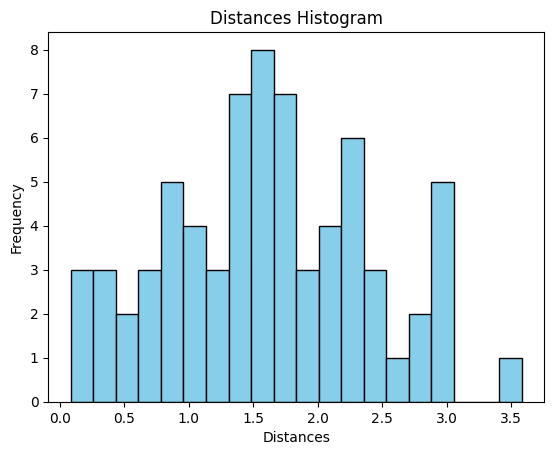

In [235]:
data = []
if m.status == GRB.OPTIMAL:
    for i in I:
            for j in J:
                if x[i,j].x > 0.5:
                    data.append(haversine(lon1[i], lat1[i], lon2[j], lat2[j]))
plt.hist(data, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Distances')
plt.ylabel('Frequency')
plt.title('Distances Histogram')
plt.show()

#### Second Model: Capacity Increase

In [306]:
m2 = Model("unassigned")

d = distance_matrix(lat1, lon1, lat2, lon2)
I = range(len(lat1)) 
J = range(len(lat2)) 
Capacity = dfcs['Plugs'].tolist() 

x = {}
z = {}
for i in I:
    for j in J:
        x[i, j] = m2.addVar(vtype=GRB.BINARY, name=f"x_{i}{j}")
    z[i] = m2.addVar(vtype=GRB.BINARY, name=f"z_{i}")

m2.setObjective(quicksum(z[i] for i in I), GRB.MINIMIZE)

for i in I:
    m2.addConstr(quicksum(x[i, j] for j in J) + z[i] == 1)

for i in I:
    for j in J:
        m2.addConstr(x[i, j] * d[i, j] <= 2.0)

for j in J:
    m2.addConstr(quicksum(x[i, j] for i in I) <= Capacity[j])

m2.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 3194 rows, 3150 columns and 9310 nonzeros
Model fingerprint: 0xad5fe115
Variable types: 0 continuous, 3150 integer (3150 binary)
Coefficient statistics:
  Matrix range     [3e-02, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 70.0000000
Presolve removed 3081 rows and 1345 columns
Presolve time: 0.01s
Presolved: 113 rows, 1805 columns, 3564 nonzeros
Variable types: 0 continuous, 1805 integer (1805 binary)
Found heuristic solution: objective 6.0000000

Root relaxation: cutoff, 172 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0         6.0

#### Solution

In [307]:
if m2.status == GRB.OPTIMAL:
    print("Objective Value (Total Unassigned Cars):", m2.objVal)

    print("\nCar Assignments:")
    for i in I:
        assigned = False
        for j in J:
            if x[i, j].X > 0.5:
                print(f"Car {i} is assigned to station {j} (Distance: {d[i,j]})")
                assigned = True
                break
        if not assigned:
            print(f"Car {i} is not assigned to any station.")

    print("\nList of Unassigned Cars:")
    unassigned_count = 0
    for i in I:
        if z[i].X > 0.5:
            print(f"Car {i}")
            unassigned_count += 1
    
    print(f"\nTotal Unassigned Cars: {unassigned_count}")

elif m.status == GRB.INFEASIBLE:
    print("The model is infeasible; no solution exists under the given constraints.")
elif m.status == GRB.UNBOUNDED:
    print("The model is unbounded; the objective function can increase indefinitely.")
else:
    print("Optimization was terminated with status:", m2.status)

Objective Value (Total Unassigned Cars): 6.0

Car Assignments:
Car 0 is assigned to station 4 (Distance: 1.526391414082488)
Car 1 is assigned to station 0 (Distance: 1.7779095653228052)
Car 2 is assigned to station 11 (Distance: 1.9706104678871594)
Car 3 is assigned to station 4 (Distance: 1.8244365689978344)
Car 4 is assigned to station 11 (Distance: 1.6553573916722701)
Car 5 is assigned to station 5 (Distance: 1.4010297571459611)
Car 6 is assigned to station 8 (Distance: 1.9873469394768428)
Car 7 is assigned to station 0 (Distance: 1.3878014897545785)
Car 8 is assigned to station 0 (Distance: 0.38033973848139757)
Car 9 is assigned to station 12 (Distance: 1.6843065195558586)
Car 10 is assigned to station 5 (Distance: 1.7264686890935894)
Car 11 is assigned to station 7 (Distance: 1.4356467119743215)
Car 12 is assigned to station 1 (Distance: 1.8217010568577716)
Car 13 is assigned to station 7 (Distance: 1.7697050044664118)
Car 14 is assigned to station 2 (Distance: 1.9821235872423315)